<a href="https://colab.research.google.com/github/sibhap/CSE_6250_Project/blob/master/KSI%2BLSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

MessageError: ignored

In [ ]:
!pip install stop-words

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for stop-words: filename=stop_words-2018.7.23-py3-none-any.whl size=32910 sha256=6be12be1079ca5b3290f5c305bc978c841f1cfe594e8055ebe61abedf60f3281
  Stored in directory: /root/.cache/pip/wheels/fb/86/b2/277b10b1ce9f73ce15059bf6975d4547cc4ec3feeb651978e9
Successfully built stop-words


In [3]:
%cd /content/drive/MyDrive/CS6250

/content/drive/MyDrive/CS6250


In [ ]:
!python preprocessing1.py

Traceback (most recent call last):
  File "preprocessing1.py", line 17, in <module>
    for row in spamreader:
  File "/usr/lib/python3.7/codecs.py", line 319, in decode
    def decode(self, input, final=False):
KeyboardInterrupt


In [ ]:
!python preprocessing2.py

tcmalloc: large alloc 5134286848 bytes == 0x5c50a000 @  0x7ff2b05b7001 0x7ff2adf461af 0x7ff2adf9cc23 0x7ff2adf9da87 0x7ff2ae03f823 0x58f62c 0x510bf2 0x58fd37 0x510325 0x5b4ee6 0x58ff2e 0x510325 0x4bac0a 0x4d3249 0x5917ee 0x591ac9 0x539167 0x50cb08 0x5b4ee6 0x6005a3 0x607796 0x60785c 0x60a436 0x64db82 0x64dd2e 0x7ff2b01b2c87 0x5b636a
tcmalloc: large alloc 5134286848 bytes == 0x18f328000 @  0x7ff2b05b51e7 0x7ff2adf460ce 0x7ff2adfa0726 0x7ff2adfa0b09 0x7ff2adfa2620 0x7ff2adfa2d1b 0x7ff2ae043333 0x58f62c 0x510bf2 0x5b4ee6 0x6005a3 0x607796 0x60785c 0x60a436 0x64db82 0x64dd2e 0x7ff2b01b2c87 0x5b636a


In [ ]:
!python preprocessing3.py

tcmalloc: large alloc 5134286848 bytes == 0x1f1a2000 @  0x7f99eb4d81e7 0x7f99e8e290ce 0x7f99e8e80e57 0x7f99e8e81a6f 0x7f99e8f27c5d 0x58f795 0x510bf2 0x5b4ee6 0x58ff2e 0x50d482 0x5b4ee6 0x58ff2e 0x510325 0x5b4ee6 0x6005a3 0x607796 0x60785c 0x60a436 0x64db82 0x64dd2e 0x7f99eb0d5c87 0x5b636a
preprocessing3.py:98: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  data=np.array(data)


In [ ]:
!pip install tensorflow

In [ ]:
!pip install keras

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install h5py

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
# from tensorflow.keras.models import Sequential
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, Input, MaxPooling1D, Convolution1D, Embedding
from keras.layers import Concatenate
from keras.datasets import imdb
from keras.preprocessing import sequence
from keras import regularizers
import joblib
from sklearn.metrics import roc_auc_score
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import time

In [5]:
label_to_ix=np.load('label_to_ix.npy', allow_pickle=True).item()
ix_to_label=np.load('ix_to_label.npy', allow_pickle=True)
training_data=np.load('training_data.npy', allow_pickle=True)
test_data=np.load('test_data.npy', allow_pickle=True)
val_data=np.load('val_data.npy', allow_pickle=True)
word_to_ix=np.load('word_to_ix.npy', allow_pickle=True).item()
ix_to_word=np.load('ix_to_word.npy', allow_pickle=True)
newwikivec=np.load('newwikivec.npy', allow_pickle=True)
wikivoc=np.load('wikivoc.npy', allow_pickle=True).item()
print(len(word_to_ix))

47960


In [6]:
# word_to_ix=np.load('word_to_ix.npy', allow_pickle=True).item()
# print(len(word_to_ix))
EMBEDDING_SIZE = 100
hidden_dim=500
maxlen = 200
MAX_SEQ_LENGTH = 12173
MAX_VOCAB = len(word_to_ix)
num_classes = len(label_to_ix)

# ix_to_word=np.load('ix_to_word.npy', allow_pickle=True)
# newwikivec=np.load('newwikivec.npy', allow_pickle=True)
# wikivoc=np.load('wikivoc.npy', allow_pickle=True).item()

# LSTM Base Model - With optional wiki data

In [25]:
import keras.backend as K
from keras.layers import Layer

# class KSIModel(keras.Model):
#     def train_step(self, data):
#         # Unpack the data. Its structure depends on your model and
#         # on what you pass to `fit()`.
#         x, y = data

#         with tf.GradientTape() as tape:
#             y_pred = self(x, training=True)  # Forward pass
#             # Compute the loss value
#             # (the loss function is configured in `compile()`)
#             loss = self.compiled_loss(y, y_pred, regularization_losses=self.losses)

#         # Compute gradients
#         trainable_vars = self.trainable_variables
#         gradients = tape.gradient(loss, trainable_vars)
#         # Update weights
#         self.optimizer.apply_gradients(zip(gradients, trainable_vars))
#         # Update metrics (includes the metric that tracks the loss)
#         self.compiled_metrics.update_state(y, y_pred)
#         # Return a dict mapping metric names to current value
#         return {m.name: m.result() for m in self.metrics}

class KSI(keras.layers.Layer):
    def __init__(self):
        super(KSI, self).__init__()
    def __init__(self, name=None, **kwargs):
        super(KSI, self).__init__(name=name)
        super(KSI, self).__init__(**kwargs)    

    def get_config(self):
        config = super(KSI, self).get_config()
        return config            

    def build(self,input_shape):
        # print("inputs shape")
        # print(input_shape)
        pass

    def call(self, inputs):
        # print("inputs shape " + inputs.shape)
        wiki = newwikivec

        notes_input1 = keras.layers.Reshape((1, -1))(inputs)
        notes_input2 = tf.repeat(notes_input1, repeats=[wiki.shape[0]], axis=1)
        
        wiki=wiki.reshape(1,wiki.shape[0], wiki.shape[1])
        
        # list = inputs.get_shape().as_list()
        # no_of_repeats = list[0]
        # wiki=tf.repeat(wiki, repeats=no_of_repeats, axis=0)

        # shape = K.shape(inputs)
        # print("printing k.shape")
        # print(shape[0])
        # print(shape[1])

        # a = Input(shape=(10, 5))
        batch_size = K.shape(inputs)[0]
        # constant = K.variable(np.ones((1,10, 5)))
        # print(wiki.shape)
        # print(batch_size)
        constant = K.tile(wiki, (batch_size, 1, 1))
        # print(constant.shape)        
        # pool_shape = tf.pack([shape[0], ...])  # Here you can mix integers and symbolic elements of `shape`
        # input_reshaped = K.reshape(x, pool_shape)
        
        # wiki_input = K.variable(wiki)
        wiki_input = constant
        new = multiply([notes_input2, wiki_input])
        new1 = layers.Dense(EMBEDDING_SIZE)(new)
        attention_layer = Dense(EMBEDDING_SIZE)(new1)
        vattention = tf.keras.activations.sigmoid(attention_layer)
        multiplied1 = multiply([vattention, new1])
        output = layers.Dense(1, activation=None)(multiplied1)
        output1 = keras.layers.Reshape((num_classes,))(output)
        return output1



In [8]:
# Create the model:
from keras import backend as K
from keras.layers import multiply

# EMBEDDING_SIZE = 100
# hidden_dim=500
# maxlen = 200
# MAX_SEQ_LENGTH = 12173
# MAX_VOCAB = len(word_to_ix)
# num_classes = len(label_to_ix)
# batch_size=64

def build_lstm_model(input_length, embedding_size, max_vocab, num_filters, filter_sizes, training_dropout_keep_prob, num_classes, use_wiki=False):
  model_input = Input(shape=input_length)
  model = keras.models.Sequential()
  model.add(Embedding(max_vocab + 1, embedding_size, input_length=input_length, embeddings_regularizer=regularizers.l2(0.0001),name="embedding"))
  model.add(layers.LSTM(64, dropout=0.1))
  model.add(layers.Dense(num_classes, activation="sigmoid"))
  model.summary()
  # loss = keras.losses.BinaryCrossentropy(from_logits=False)
  # optim = keras.optimizers.Adam(learning_rate=0.001)
  # metrics = ["accuracy"]
  # model.compile(loss=loss, optimizer=optim, metrics=metrics)  
  return model
def build_attention_model(wiki, input_length, embedding_size, max_vocab, num_filters, filter_sizes, training_dropout_keep_prob, num_classes):

  notes_input = Input(shape=(None,), name="notes") 
  # notes_input1 = keras.layers.Reshape((1, -1))(notes_input)
  # notes_input2 = tf.repeat(notes_input1, repeats=[wiki.shape[0]], axis=1)
  # wiki=wiki.reshape(1,wiki.shape[0], wiki.shape[1])
  # ## no_of_repeats = batch_size 
  # ## list = notes_input2.get_shape().as_list()
  # ## print(list)
  # ## if list[0] is not None:
  # ##   no_of_repeats = list[0]
  # ## wiki=tf.repeat(wiki, repeats=None, axis=0)
  # batch_size = K.shape(notes_input)[0]
  # wiki_input = K.tile(wiki, (batch_size, 1, 1))

  # ## wiki_input = K.variable(wiki)
  # new = multiply([notes_input2, wiki_input])
  # new1 = layers.Dense(EMBEDDING_SIZE)(new)
  # attention_layer = Dense(EMBEDDING_SIZE)(new1)
  # vattention = tf.keras.activations.sigmoid(attention_layer)
  # multiplied1 = multiply([vattention, new1])
  # output = layers.Dense(1, activation=None)(multiplied1)
  # output1 = keras.layers.Reshape((num_classes,))(output)

  output1 = KSI()(notes_input)

  model = keras.Model(
    inputs=[notes_input],
    outputs=[output1], name="KSI"
  )
  return model  

In [9]:
# cnn_model = build_cnn_model(input_length=MAX_SEQ_LENGTH, embedding_size=EMBEDDING_SIZE, max_vocab = MAX_VOCAB, num_filters = 100, filter_sizes=[2,3,4,5],
#                              training_dropout_keep_prob=0.5, num_classes = num_classes)
# print(cnn_model.summary())
lstm_model1 = build_lstm_model(input_length=MAX_SEQ_LENGTH, embedding_size=EMBEDDING_SIZE, max_vocab = MAX_VOCAB, num_filters = 100, filter_sizes=[2,3,4,5],
                             training_dropout_keep_prob=0.5, num_classes = num_classes)
attention_model = build_attention_model(newwikivec, input_length=MAX_SEQ_LENGTH, embedding_size=EMBEDDING_SIZE, max_vocab = MAX_VOCAB, num_filters = 100, filter_sizes=[2,3,4,5],
                             training_dropout_keep_prob=0.5, num_classes = num_classes)
print("lstm model output shape")
print(lstm_model1.output.shape)

print("attn model output shape")
print(attention_model.output.shape)

mergedOut = tf.keras.layers.Add()([lstm_model1.output, attention_model.output])

lstm_model = Model([lstm_model1.input,attention_model.input], mergedOut)
loss = keras.losses.BinaryCrossentropy(from_logits=False)
optim = keras.optimizers.Adam(learning_rate=0.001)
metrics = ["accuracy"]
lstm_model.compile(loss=loss, optimizer=optim, metrics=metrics)  

print(lstm_model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 12173, 100)        4796100   
                                                                 
 lstm (LSTM)                 (None, 64)                42240     
                                                                 
 dense (Dense)               (None, 344)               22360     
                                                                 
Total params: 4,860,700
Trainable params: 4,860,700
Non-trainable params: 0
_________________________________________________________________
lstm model output shape
(None, 344)
attn model output shape
(None, 344)
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 embedding_input (InputLa

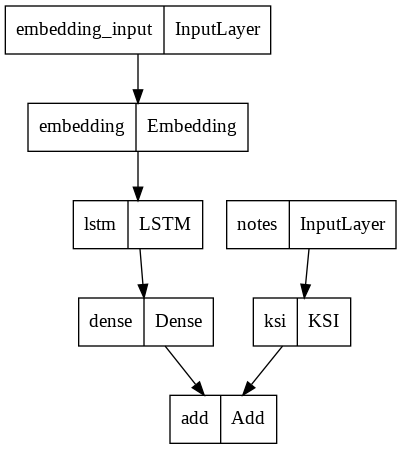

In [10]:
from keras.utils import plot_model
from IPython.display import Image
plot_model(lstm_model,'lstm_base.png')
Image('lstm_base.png')

In [11]:
count = [len(x[0]) for x in training_data]

In [12]:
min(count), max(count), np.mean(count), np.median(count)

(36, 5285, 1023.7772870149578, 937.0)

In [13]:
def get_data(input_data):
  # training_data is of the form (list of list of words, notes, y )
  #training_data[0]
  #array([list(['admission', 'date', 'discharge', 'date', 'date', 
  #array([1., 1., 1., ..., 0., 0., 0.]),
       #list(['d_427', 'd_423', 'd_458', 'd_401', 'd_272', 'd_250', 'd_424'])],
  x_data =  [[word_to_ix[x] for x in record[0] if x in word_to_ix] for record in input_data]
  x_data = tf.keras.utils.pad_sequences(x_data, maxlen=MAX_SEQ_LENGTH, padding="post")
  y_data = [[label_to_ix[x] for x in record[2] if x in label_to_ix] for record in input_data]
  ylabel_count = np.array([len(item) for item in y_data])
  arg_zero = np.argwhere(ylabel_count == 0)
  y_data = [y_data[i] for i in range(len(y_data)) if i not in arg_zero]
  x_data = [x_data[i] for i in range(len(x_data)) if i not in arg_zero]
  x_data = np.array(x_data)
  for idx, item in enumerate(y_data):
    y = np.zeros(len(label_to_ix),)
    y[item] = 1
    y_data[idx] = y
  y_data = np.array(y_data)
  return x_data, y_data

In [14]:
train_x, train_y = get_data(training_data)

In [15]:
train_y.shape, train_x.shape
# ((34898, 344), (34898, 100))

((34898, 344), (34898, 12173))

In [37]:
val_x, val_y = get_data(val_data)
test_x, test_y = get_data(test_data)

In [38]:
val_y.shape, val_x.shape, test_y.shape, test_x.shape

((5022, 344), (5022, 12173), (9985, 344), (9985, 12173))

In [18]:
def train_lstm_model(train_x, train_y, val_x, val_y, batch_size=32, epochs=20):
  tf.config.run_functions_eagerly(True) # https://stackoverflow.com/questions/58352326/running-the-tensorflow-2-0-code-gives-valueerror-tf-function-decorated-functio
  lstm_model.fit([train_x, train_x], train_y, validation_data=([val_x, val_x], val_y), batch_size=batch_size, epochs=epochs, verbose=2)
  # save model
  lstm_model.save('lstm_20_epochs_attn1.h5')

In [21]:
import os
path='lstm_20_epochs_attn1.h5'
isExist = os.path.exists(path)
isExist

True

In [26]:
from keras.models import load_model
if not isExist:
  train_lstm_model(train_x, train_y, val_x, val_y, batch_size=64, epochs=20)

model = load_model('lstm_20_epochs_attn1.h5', custom_objects={"KSI": KSI})


In [27]:
#prediction for training data
pred_train = model.predict([train_x, train_x], batch_size=50)
pred_train

/usr/local/lib/python3.8/dist-packages/tensorflow/python/data/ops/structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


698/698 [==============================] - 164s 235ms/step


array([[  -72.35643  ,   -13.224892 ,    14.515126 , ...,    -1.7645541,
          -49.0138   ,   -38.351387 ],
       [ -249.56377  ,   -31.04177  ,  -103.64335  , ...,  -112.25918  ,
         -173.41917  ,  -109.94698  ],
       [   26.088898 ,   -23.694963 ,   -12.343065 , ...,    76.64265  ,
          -77.86034  ,  -128.44875  ],
       ...,
       [-1120.7474   ,  1611.3993   , -1760.3197   , ...,  -719.98816  ,
         -256.54007  ,  -387.2008   ],
       [ -484.3089   ,    45.726295 ,    18.69176  , ...,   115.26921  ,
         -461.7434   ,   185.13025  ],
       [ -600.1836   ,   641.6994   ,  1127.2299   , ...,  1268.9268   ,
          100.75515  ,   -21.28305  ]], dtype=float32)

In [29]:
#prediction for validation data
pred_val = model.predict([val_x, val_x], batch_size=100)
pred_val

/usr/local/lib/python3.8/dist-packages/tensorflow/python/data/ops/structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


51/51 [==============================] - 16s 306ms/step


array([[ -295.8833  ,   235.60309 ,  -413.63422 , ...,  -659.50085 ,
         -906.8581  , -1646.4597  ],
       [ 2472.8235  ,  -698.4535  ,  -641.7065  , ..., -1135.6082  ,
         -914.6792  ,  -520.92456 ],
       [ 1185.4603  ,    44.747066,  -349.91232 , ...,  -923.78326 ,
         -826.4393  ,   -47.07787 ],
       ...,
       [  878.28906 ,   238.21574 ,  -272.98016 , ...,  -272.93076 ,
         -988.649   ,  -416.60928 ],
       [ 1452.1742  ,  -885.7985  ,  -706.04083 , ...,  -448.4215  ,
         -231.63599 ,    88.36158 ],
       [ -281.643   ,   233.5226  ,  -170.00453 , ...,  -716.1015  ,
         -264.37457 ,   621.8988  ]], dtype=float32)

In [30]:
val_y.shape, pred_val.shape

((5022, 344), (5022, 344))

In [31]:
from sklearn.metrics import f1_score, roc_auc_score
def get_f1_score(y_actual, pred_val):
  y_final = np.where(np.array(pred_val) > 0.005, 1, 0)
  f1score_macro = f1_score(np.array(y_actual), y_final, average="macro")
  print(f"f1score_macro = {f1score_macro}")
  f1score_micro = f1_score(np.array(y_actual), y_final, average="micro")
  print(f"f1score_micro = {f1score_micro}")
  return f1score_macro, f1score_micro


In [32]:
# f1score_micro = f1_score(np.array(train_y), y_final, average="micro")
# f1score_micro

In [40]:
#prediction for test data
pred_test = model.predict([test_x, test_x], batch_size=100)
pred_test

/usr/local/lib/python3.8/dist-packages/tensorflow/python/data/ops/structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


100/100 [==============================] - 31s 311ms/step


array([[-1747.9214   ,  1990.6636   ,  1071.0496   , ...,   165.39014  ,
         -680.9455   ,    85.70825  ],
       [ 3071.1453   ,  1875.661    ,  1872.3832   , ...,   880.8743   ,
          497.88504  ,  1349.9421   ],
       [  887.0019   ,    -7.3701024,   568.3991   , ...,   188.12018  ,
         1035.6218   ,  1090.9043   ],
       ...,
       [ -365.0593   ,  1311.3204   ,  1093.863    , ...,   184.61406  ,
           79.87815  ,   821.69794  ],
       [ -244.46619  ,  -391.1204   ,  -222.20425  , ...,   778.62555  ,
         -582.7086   , -1155.0293   ],
       [ -644.641    ,   192.68448  , -1842.2162   , ...,  -947.6394   ,
         -493.26358  , -1811.7106   ]], dtype=float32)

In [41]:
f1score_macro, f1score_micro = get_f1_score(val_y, pred_val)
f1score_macro, f1score_micro

f1score_macro = 0.02618712990877349
f1score_micro = 0.03228908246136585


(0.02618712990877349, 0.03228908246136585)

In [42]:
f1score_test_macro, f1score_test_micro = get_f1_score(test_y, pred_test)
f1score_test_macro, f1score_test_micro

f1score_macro = 0.026584815586941587
f1score_micro = 0.032189539778965895


(0.026584815586941587, 0.032189539778965895)

In [43]:
y_final = np.where(np.array(pred_val) > 0.005, 1, 0)
print(len(np.unique(y_final)))
print(len(np.unique(val_y)))
# auc_macro = roc_auc_score(val_y, y_final, average="macro", multi_class="ovo")
# print(f"auc_macro = {auc_macro}")
auc_micro = roc_auc_score(val_y, y_final, average="micro")
print(f"auc_micro = {auc_micro}")

2
2
auc_micro = 0.503117431809168


In [44]:
y_final_test = np.where(np.array(pred_test) > 0.005, 1, 0)
print(len(np.unique(y_final_test)))
print(len(np.unique(test_y)))
# auc_macro = roc_auc_score(test_y, y_final_test, average="macro", multi_class="ovo")
# print(f"auc_macro = {auc_macro}")
auc_micro = roc_auc_score(test_y, y_final_test, average="micro")
print(f"auc_micro = {auc_micro}")

2
2
auc_micro = 0.4991078937087122


# Models from Original Paper

In [ ]:
!python KSI_CNN.py

KSI_CNN.py:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  new_data=np.array(new_data)
KSI_CNN.py:57: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  main_matrix = np.zeros((mybsize, numword), dtype= np.int)
start_training
0
XXXXXXXXXXXXXXXXXXXXXXXXXXXX
validation top- 10 0.447759546015512
1
XXXXXXXXXXXXXXXXXXXXXXXXXXXX
validati

In [ ]:
!python KSI_LSTM.py

KSI_LSTM.py:42: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  new_data=np.array(new_data)
KSI_LSTM.py:56: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  main_matrix = np.zeros((mybsize, numword), dtype= np.int)
start_training
0
XXXXXXXXXXXXXXXXXXXXXXXXXXXX
validation top- 10 0.4288319600440542
1
XXXXXXXXXXXXXXXXXXXXXXXXXXXX
valid

In [ ]:
!python KSI_LSTMatt.py

KSI_LSTMatt.py:42: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  new_data=np.array(new_data)
KSI_LSTMatt.py:56: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  main_matrix = np.zeros((mybsize, numword), dtype= np.int)
start_training
0
XXXXXXXXXXXXXXXXXXXXXXXXXXXX
validation top- 10 0.3796880833045024
1
XXXXXXXXXXXXXXXXXXXXXXXXXXXX

In [ ]:
!python KSI_CAML.py

KSI_CAML.py:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  new_data=np.array(new_data)
KSI_CAML.py:57: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  main_matrix = np.zeros((mybsize, numword), dtype= np.int)
start_training
0
XXXXXXXXXXXXXXXXXXXXXXXXXXXX
validation top- 10 0.6044048484082241
1
XXXXXXXXXXXXXXXXXXXXXXXXXXXX
valid